In [46]:
import pandas as pd
import numpy as np
from modules.config import DATA_PATH_V2, TAXI_ZONE_PATH, WEATHER_NYC_PATH
import pyarrow.parquet as pq
pd.set_option('display.max_columns', None) 

In [47]:
trips = pq.read_table(DATA_PATH_V2)  
trips = trips.to_pandas()
zone = pd.read_csv(TAXI_ZONE_PATH)
weather = pd.read_csv(WEATHER_NYC_PATH)

In [81]:
uber_trips = trips[trips["hvfhs_license_num"] == "HV0003"]
uber_trips = uber_trips[uber_trips['trip_miles'] > 0]

In [82]:
uber_trips['out_of_base_dispatch_flag'] = np.where(uber_trips['dispatching_base_num'] != uber_trips['originating_base_num'], 1, 0)
uber_trips['airport_fee'] = uber_trips['airport_fee'].fillna(0)
uber_trips['final_fare'] = uber_trips["base_passenger_fare"] + uber_trips["tolls"] + uber_trips['bcf'] + uber_trips['sales_tax'] + uber_trips['congestion_surcharge'] + uber_trips["airport_fee"]
uber_trips['uber_profit'] = uber_trips['final_fare'] - uber_trips['driver_pay']
uber_trips['driver_final_pay'] = uber_trips['driver_pay'] + uber_trips['tips'] - (uber_trips["tolls"] + uber_trips['bcf'] + uber_trips['sales_tax'] + uber_trips['congestion_surcharge'] + uber_trips["airport_fee"])
uber_trips['tipper_flag'] = np.where(uber_trips['tips'] > 0, 1, 0)
uber_trips['uber_profit_per_mile'] = uber_trips['uber_profit'] / uber_trips['trip_miles']
uber_trips['uber_profit_per_second'] = uber_trips['uber_profit'] / uber_trips['trip_time']
uber_trips["pickup_date"] = uber_trips["pickup_datetime"].dt.date
uber_trips['wait'] = round((uber_trips['pickup_datetime'] - uber_trips['request_datetime']).dt.total_seconds(), 0)
hours = uber_trips["pickup_datetime"].dt.hour
conditions = [
    (hours >= 23) | (hours < 1),   
    (hours >= 1) & (hours < 5),    
    (hours >= 5) & (hours < 11),   
    (hours >= 11) & (hours < 17), 
    (hours >= 17) & (hours < 23),  
]
labels = ["night", "late", "morning", "midday", "evening"]

uber_trips["time_of_day"] = np.select(conditions, labels, default="night")
uber_trips["pickup_date"] = pd.to_datetime(uber_trips["pickup_datetime"]).dt.normalize()
weather["datetime"] = pd.to_datetime(weather["datetime"]).dt.normalize()

uber_trips = uber_trips.merge(
    weather[["datetime", "precip", "preciptype"]],
    left_on="pickup_date",
    right_on="datetime",
    how="left"
)

uber_trips['preciptype'] = uber_trips['preciptype'].fillna('None')
uber_trips.drop(columns=["hvfhs_license_num", "dispatching_base_num", "originating_base_num",
                         "on_scene_datetime", "access_a_ride_flag", "wav_request_flag",
                         "wav_match_flag", "base_passenger_fare", "tolls", "bcf", "sales_tax", 
                         "congestion_surcharge", "airport_fee", "driver_pay", "pickup_datetime",
                         "request_datetime", "dropoff_datetime", "datetime"], inplace=True)
uber_trips = uber_trips.reset_index(drop=True)
uber_trips["ride_id"] = uber_trips.index + 1

Variance Inflation Factor (VIF):
                      Feature         VIF
6                  final_fare  172.399071
8            driver_final_pay   44.927267
7                 uber_profit   41.861855
3                   trip_time   15.812016
2                  trip_miles   13.542696
11     uber_profit_per_second    4.107602
1                DOLocationID    3.824469
12                       wait    3.758748
0                PULocationID    3.714871
14                    ride_id    3.532185
4                        tips    3.132964
9                 tipper_flag    2.436596
13                     precip    1.192313
10       uber_profit_per_mile    1.125932
5   out_of_base_dispatch_flag    1.000986

Correlation Matrix:
                           PULocationID  DOLocationID  trip_miles  trip_time  \
PULocationID                   1.000000      0.142856    0.007155  -0.008883   
DOLocationID                   0.142856      1.000000    0.084426   0.041910   
trip_miles                     0.0

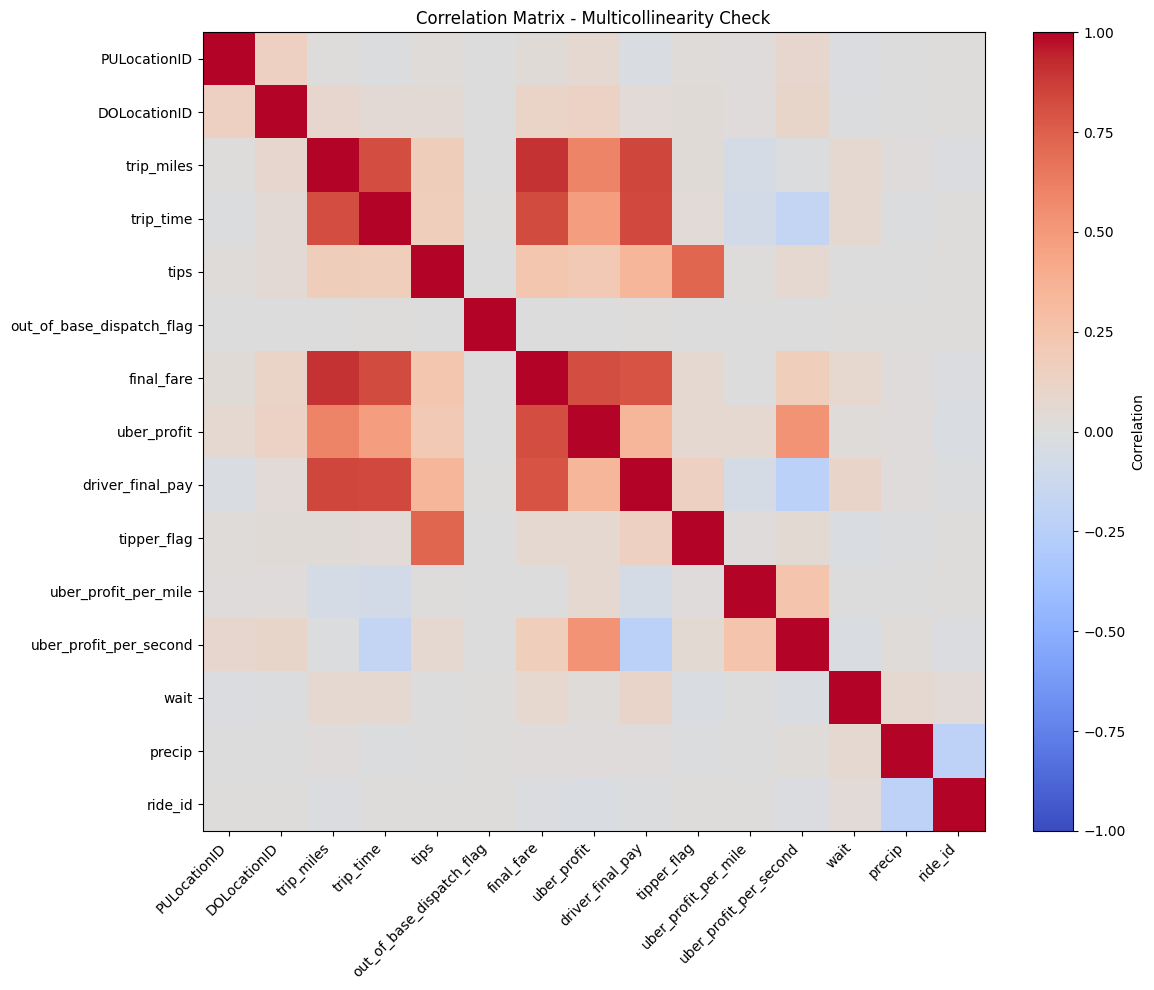

In [84]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

numeric_cols = uber_trips.select_dtypes(include=[np.number]).columns
X = uber_trips[numeric_cols]

vif_data = pd.DataFrame()
vif_data["Feature"] = numeric_cols
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("Variance Inflation Factor (VIF):")
print(vif_data.sort_values("VIF", ascending=False))

print("\nCorrelation Matrix:")
correlation = X.corr()
print(correlation)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))
plt.imshow(correlation, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=45, ha='right')
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.title("Correlation Matrix - Multicollinearity Check")
plt.tight_layout()
plt.show()

In [64]:
uber_trips.columns

Index(['PULocationID', 'DOLocationID', 'trip_miles', 'trip_time', 'tips',
       'shared_request_flag', 'shared_match_flag', 'out_of_base_dispatch_flag',
       'final_fare', 'uber_profit', 'driver_final_pay', 'tipper_flag',
       'uber_profit_per_mile', 'uber_profit_per_second', 'pickup_date', 'wait',
       'time_of_day', 'precip', 'preciptype', 'ride_id'],
      dtype='str')